In [1]:
import time

In [ ]:
# The code to generate the Penrose tiling below is taken from https://github.com/xnx/penrose
import math
import cmath
import cairo
import matplotlib.pyplot as plt
import numpy as np

#------ Configuration --------
IMAGE_SIZE = (1000, 1000)
NUM_SUBDIVISIONS = 4
# For paper, use NUM_SUBDIVISIONS = 8
#-----------------------------


goldenRatio = (1 + math.sqrt(5)) / 2

def subdivide(triangles):
    result = []
    for color, A, B, C in triangles:
        if color == 0:
            # Subdivide red triangle
            P = A + (B - A) / goldenRatio
            result += [(0, C, P, B), (1, P, C, A)]
        else:
            # Subdivide blue triangle
            Q = B + (A - B) / goldenRatio
            R = B + (C - B) / goldenRatio
            result += [(1, R, C, A), (1, Q, R, B), (0, R, Q, A)]
    return result

# Create wheel of red triangles around the origin
triangles = []
for i in range(10):
    B = cmath.rect(1, (2*i - 1) * math.pi / 10)
    C = cmath.rect(1, (2*i + 1) * math.pi / 10)
    if i % 2 == 0:
        B, C = C, B  # Make sure to mirror every second triangle
    triangles.append((0, 0j, B, C))

# Perform subdivisions
for i in range(NUM_SUBDIVISIONS):
    triangles = subdivide(triangles)

# Prepare cairo surface
surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, IMAGE_SIZE[0], IMAGE_SIZE[1])
cr = cairo.Context(surface)
cr.translate(IMAGE_SIZE[0]/2 , IMAGE_SIZE[1]/2 )
wheelRadius = 0.5 * math.sqrt((IMAGE_SIZE[0] / 2.0) ** 2 + (IMAGE_SIZE[1] / 2.0) ** 2)
#wheelRadius = 1.2 * math.sqrt((IMAGE_SIZE[0] / 2.0) ** 2 + (IMAGE_SIZE[1] / 2.0) ** 2)
cr.scale(wheelRadius, wheelRadius)



# Draw red triangles
for color, A, B, C in triangles:
    if color == 0:
        cr.move_to(A.real, A.imag)
        cr.line_to(B.real, B.imag)
        cr.line_to(C.real, C.imag)
        cr.close_path()
cr.set_source_rgb(0.984, 0.827, 0.827)
cr.fill()    


# Draw blue triangles
for color, A, B, C in triangles:
    if color == 1:
        cr.move_to(A.real, A.imag)
        cr.line_to(B.real, B.imag)
        cr.line_to(C.real, C.imag)
        cr.close_path()
cr.set_source_rgb(0.82, 0.83, 1.0)
cr.fill()

# Determine line width from size of first triangle
color, A, B, C = triangles[0]
cr.set_line_width(abs(B - A) / 20.0)
cr.set_line_join(cairo.LINE_JOIN_ROUND)

# Draw outlines
for color, A, B, C in triangles:
    cr.move_to(C.real, C.imag)
    cr.line_to(A.real, A.imag)
    cr.line_to(B.real, B.imag)
cr.set_source_rgb(0.2, 0.2, 0.2)
cr.stroke()

# Save to PNG
surface.write_to_png('trial.png')
# surface.write_to_png('penrose'+str(NUM_SUBDIVISIONS)+'.png')


In [3]:
color, A, B, C = triangles[0]
lat_scale = abs(A-B)

pts_dupes = []
lat_A_dupes = []
lat_B_dupes = []

for i in range(len(triangles)):
    color, A, B, C = triangles[i]
    pts_dupes.append(A)
    pts_dupes.append(B)
    pts_dupes.append(C)
    if color==0:
        lat_A_dupes.append(A)
        lat_B_dupes.append(B)
        lat_B_dupes.append(C)
    else:
        lat_A_dupes.append(B)
        lat_A_dupes.append(C)
        lat_B_dupes.append(A)

pts_dupes = np.array(pts_dupes)/lat_scale
lat_A_dupes = np.array(lat_A_dupes)/lat_scale
lat_B_dupes = np.array(lat_B_dupes)/lat_scale

pts = []
filled = np.zeros(len(pts_dupes))
for i in range(len(pts_dupes)-1):
    if filled[i] == 1:
        continue

    for j in range(i+1,len(pts_dupes)):
        if abs(pts_dupes[i] - pts_dupes[j]) < 1e-5:
            filled[j] = 1
            
    pts.append(pts_dupes[i])


lattice = np.zeros(len(pts))
center = np.argmin(np.abs(pts))
visited = [np.argmin(np.abs(pts))]
npts = len(pts)
lat_A = []
lat_B = []
graph = np.zeros((npts, npts))
for i in range(npts):
    for j in range(npts):
        if abs(abs(pts[i]-pts[j]) - 1.0) < 1e-5:
            graph[i,j] = 1
            graph[j,i] = 1
            

lattice[center] = 1

count = 0

while count < 100:
    count += 1
    visited_copy = np.copy(visited)
    for site in visited_copy:
        for i in range(len(pts)):
            if (abs(abs(pts[i] - pts[site]) - 1.0) < 1e-5 ) and (i not in visited):
                lattice[i] = 1-lattice[site]
                visited.append(i)

for i in range(len(pts)):
    if lattice[i] == 1.0:
        lat_A.append(i)
    else:
        lat_B.append(i)


In [4]:
pts_x = np.real(pts)
pts_y = np.imag(pts)

In [5]:
lat_scale = 1.0

edges = []

graph = np.zeros((len(pts), len(pts)), dtype=int)

for i in range(len(pts)-1):
    for j in range(i+1, len(pts)):
        if abs(abs(pts[i] - pts[j]) - lat_scale) < 1e-5:
            edges.append([i,j])
            graph[i][j] = 1
            graph[j][i] = 1
            


def edge_plotting(edges):
    plt_edges_x = []
    plt_edges_y = []
    for i in range(len(edges)):
        plt_edges_x.append(np.real(pts[edges[i][0]]))
        plt_edges_y.append(np.imag(pts[edges[i][0]]))
        plt_edges_x.append(np.real(pts[edges[i][1]]))
        plt_edges_y.append(np.imag(pts[edges[i][1]]))
        plt_edges_x.append(None)
        plt_edges_y.append(None)
    return (plt_edges_x, plt_edges_y)


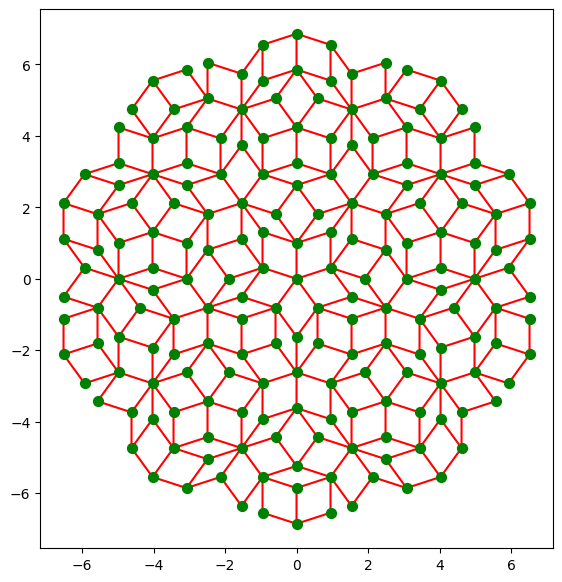

In [6]:
fig, ax = plt.subplots(1, 1,figsize=(7, 7))
(plt_edges_x, plt_edges_y) = edge_plotting(edges)
ax.plot(plt_edges_x, plt_edges_y,color = 'red',zorder =1)
s = 50
plt.scatter(pts_x, pts_y, s=s, color='green')
#plt.scatter(center_x, center_y, s=20)

ax.set_aspect('equal')

In [7]:
lat_A = []
lat_B = []

AtoG = []
BtoG = []

ind_A = np.zeros(npts, dtype=int) + npts + 10
ind_B = np.zeros(npts, dtype=int) + npts + 10
col = np.zeros(npts, dtype=int)

col[0] = 1
stack = [0]

while len(stack) > 0:
    current = stack.pop()
    for i in range(npts):
        if graph[current][i] == 1 and col[i] == 0:
            col[i] = -col[current]
            stack.append(i)      

for i in range(npts):
    if col[i] == 1:
        lat_A.append(pts[i])
        ind_A[i] = len(lat_A) - 1
        AtoG.append(i)
    elif col[i] == -1:
        lat_B.append(pts[i])
        ind_B[i] = len(lat_B) - 1
        BtoG.append(i)


In [8]:
from hopcroftkarp import HopcroftKarp

g = {}
gphA = [[] for _ in range(len(lat_A))]
gphB = [[] for _ in range(len(lat_B))]

for i in range(len(lat_A)):
    g[str(i)] = []

    
for i in range(npts-1):
    for j in range(i+1, npts):
        if graph[i][j] == 1:
            if ind_A[i] < npts + 1 and ind_B[j] < npts + 1:
                g[str(ind_A[i])].append(ind_B[j])
                gphA[ind_A[i]].append(ind_B[j])
                gphB[ind_B[j]].append(ind_A[i])
                #print(ind_A[i], ind_B[j], "l")
            elif ind_A[j] < npts + 1 and ind_B[i] < npts + 1:
                g[str(ind_A[j])].append(ind_B[i])
                gphA[ind_A[j]].append(ind_B[i])
                gphB[ind_B[i]].append(ind_A[j])
                #print(ind_A[j], ind_B[i])
            else:
                print("Error!!")
                
max_match = HopcroftKarp(g).maximum_matching(keys_only=True)

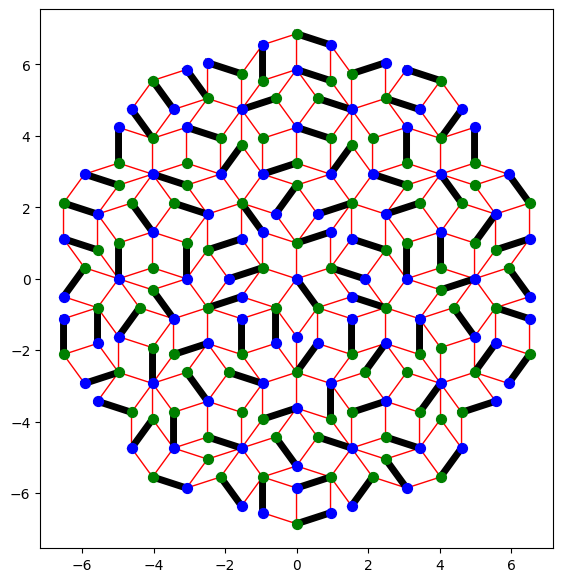

In [9]:
def plot_dimer_covering(config):
    matching_edges_x = []
    matching_edges_y = []

    temp = list(config.keys())
    max_keys = [int(temp[i]) for i in range(len(temp))]


    temp = list(config.values())
    max_values = [int(temp[i]) for i in range(len(temp))]



    for i in range(len(config)):
        matching_edges_x.append(np.real(    lat_A[ max_keys[i] ]   ))
        matching_edges_y.append(np.imag(    lat_A[ max_keys[i] ]   ))
        matching_edges_x.append(np.real(    lat_B[ max_values[i] ] ))
        matching_edges_y.append(np.imag(    lat_B[ max_values[i] ] ))
        matching_edges_x.append(None)
        matching_edges_y.append(None)

    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    s = 50
    plt.scatter(np.real(lat_A), np.imag(lat_A), s=s, color = 'blue', zorder=1)
    plt.scatter(np.real(lat_B), np.imag(lat_B), s=s, color = 'green', zorder=1)
    #plt.scatter(center_x, center_y, s=20)
    ax.plot(plt_edges_x, plt_edges_y,color = 'red',  linewidth=1, zorder=-1)
    ax.plot(matching_edges_x, matching_edges_y,color = 'black', linewidth=5, zorder=-1)
    #ax.plot(mem_edges_x, mem_edges_y,color = 'magenta', zorder=1, linewidth = 3)
    
    # for i in range(npts):
    #     ax.annotate( str(i) , (np.real(pts)[i], np.imag(pts)[i]))

    ax.set_aspect('equal')
    #plt.show()
    
plot_dimer_covering(max_match)

# Getting a handle on the plaquettes


gph[index_A] stores the indices of the neighbors of the point lat_A[index_A] relative to the lat_B array

In [10]:
plaq_dupes = []
# convention for the plaquette array:
# plaq_dupes[i] = [A1, B1, B2, A2]

for i in range(len(lat_A)):
    nbr = gphA[i]
    nnbr = []
    for j in nbr:
        nnbr.append(gphB[j].copy())
        nnbr[-1].remove(i)
    #print(nbr)
    #print(nnbr)
    
    for j in range(len(nnbr)-1):
        for k in range(j+1, len(nnbr)):
            #print(j,k)
            set_j = set(nnbr[j])
            set_k = set(nnbr[k])
            common = set_j & set_k
            if len(common) == 1:
                plaq_dupes.append([i, nbr[j], nbr[k], list(common)[0]])
            elif len(common) == 0:
                continue
            else:
                print("Error!!")

# each plaquette is counted twice above.
# So we need to remove the duplicates.

plaq = []

for i in range(len(plaq_dupes)-1):
    for j in range(i+1, len(plaq_dupes)):
        if plaq_dupes[i][0] == plaq_dupes[j][3] and plaq_dupes[j][0] == plaq_dupes[i][3]:
            plaq.append(plaq_dupes[i])

    

In [11]:
dual_ver = [(lat_A[p[0]] + lat_B[p[1]] + lat_B[p[2]] + lat_A[p[3]])/4 for p in plaq]
dual_edge = np.zeros((len(dual_ver), len(dual_ver)), dtype = int)
dual_edge_big = np.zeros((len(dual_ver), len(dual_ver),2), dtype = int)
dual_edge_list = []


for i in range(len(plaq)-1):
    for j in range(i+1, len(plaq)):
        [a0, b0, b1, a1] = plaq[i]
        [c0, d0, d1, c1] = plaq[j]
        edges_1 = [(a0,b0) , (a0,b1) , (a1,b0) , (a1,b1) ]
        edges_2 = [(c0,d0) , (c0,d1) , (c1,d0) , (c1,d1) ]
        common_edge = list(set(edges_1).intersection(edges_2))
        
        if common_edge != []:
            dual_edge[i][j] = 1
            dual_edge[j][i] = 1
            
            dual_edge_big[i][j][0] = common_edge[0][0]
            dual_edge_big[i][j][1] = common_edge[0][1]
            
            dual_edge_big[j][i][0] = common_edge[0][0]
            dual_edge_big[j][i][1] = common_edge[0][1]
            
            dual_edge_list.append([dual_ver[i], dual_ver[j]])
            
dual_edges_x = []
dual_edges_y = []
for i in range(len(dual_edge_list)):
    dual_edges_x.append(np.real(dual_edge_list[i][0]))
    dual_edges_y.append(np.imag(dual_edge_list[i][0]))
    
    dual_edges_x.append(np.real(dual_edge_list[i][1]))
    dual_edges_y.append(np.imag(dual_edge_list[i][1]))
    
    dual_edges_x.append(None)
    dual_edges_y.append(None) 



# Determine monomer sites

In [12]:
monomer_A = [i for i in range(len(lat_A))]
monomer_B = [i for i in range(len(lat_B))]

temp = list(max_match.keys())
max_keys = [int(temp[i]) for i in range(len(temp))]


temp = list(max_match.values())
max_values = [int(temp[i]) for i in range(len(temp))]

for i in range(len(max_match)):
    monomer_A.remove(max_keys[i])
    monomer_B.remove(max_values[i])



print(np.transpose(monomer_A))
print(np.transpose(monomer_B))

print("Monomer density is ", (len(monomer_A) + len(monomer_B))/npts)

[72]
[14 31 41 51 61 74 81 94 98 99]
Monomer density is  0.05759162303664921


# Plotting the monomer membranes

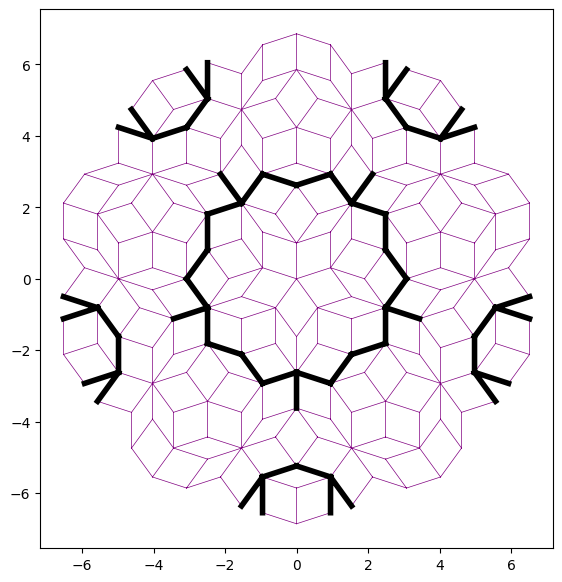

In [13]:
coordination_no = sum(graph)
even_sites = [ i for i in range(len(coordination_no))  if coordination_no[i]%2 == 0]
even_visited = [0]*len(even_sites)
to_visit = even_sites.copy()
nbr_list = [ [ i for i in range(npts) if graph[i][j] == 1] for j in range(npts)  ]
membrane_edges = []
  
for l in even_sites:
    nbr_start = nbr_list[l]
    for j in nbr_start:
        if coordination_no[j] == 5:
            membrane_edges.append([l,j])

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
(plt_edges_x, plt_edges_y) = edge_plotting(edges)
ax.plot(plt_edges_x, plt_edges_y,color = 'purple', zorder=1, linewidth=0.5)

(mem_edges_x, mem_edges_y) = edge_plotting(membrane_edges)
ax.plot(mem_edges_x, mem_edges_y,color = 'black', zorder=1, linewidth = 4)
ax.set_aspect('equal')


# Exporting data to julia

In [14]:
ngen = NUM_SUBDIVISIONS

In [15]:
begin = "./data/lattice_generation_output/center_"

In [16]:
fname = begin+str(ngen)+"_graph.txt"
np.savetxt(fname=fname, X=graph.astype(int), fmt ='%.0f')

In [17]:
fname = begin+str(ngen)+"_pts_re.txt"
np.savetxt(fname=fname, X= np.real(pts), fmt ='%.10f')

In [18]:
fname = begin+str(ngen)+"_pts_im.txt"
np.savetxt(fname=fname, X= np.imag(pts), fmt ='%.10f')

In [19]:
fname = begin+str(ngen)+"_ind_A.txt"
np.savetxt(fname=fname, X=(ind_A+1).astype(int), fmt ='%.0f')

fname = begin+str(ngen)+"_ind_B.txt"
np.savetxt(fname=fname, X=(ind_B+1).astype(int), fmt ='%.0f')

In [20]:
fname = begin+str(ngen)+"_AtoG.txt"
np.savetxt(fname=fname, X=(np.array(AtoG)+1).astype(int), fmt ='%.0f')

fname = begin+str(ngen)+"_BtoG.txt"
np.savetxt(fname=fname, X=(np.array(BtoG)+1).astype(int), fmt ='%.0f')

In [21]:
fname = begin+str(ngen)+"_plaq.txt"
np.savetxt(fname=fname, X=(np.array(plaq)+1).astype(int), fmt ='%.0f')

In [22]:
max_match_np = []

for i in max_match.keys():
    max_match_np.append([int(i)+1,max_match[i]+1])

fname = begin+str(ngen)+"_max_match.txt"
np.savetxt(fname=fname, X=np.array(max_match_np).astype(int), fmt ='%.0f')

In [23]:
fname = begin+str(ngen)+"_ABedge_no.txt"
np.savetxt(fname=fname, X=(np.array(ABedge_no)+1).astype(int), fmt ='%.0f')

NameError: name 'ABedge_no' is not defined

In [ ]:

fname = begin+str(ngen)+"_spins_to_edges.txt"
np.savetxt(fname=fname, X=(np.array(spins_to_edges)+1).astype(int), fmt ='%.0f')

In [ ]:

fname = begin+str(ngen)+"_plaq_spins.txt"
np.savetxt(fname=fname, X=(np.array(plaq_spins)+1).astype(int), fmt ='%.0f')

In [ ]:
fname = begin+str(ngen)+"_monomer_A.txt"
np.savetxt(fname=fname, X=(np.array(monomer_A)+1).astype(int), fmt ='%.0f')

fname = begin+str(ngen)+"_monomer_B.txt"
np.savetxt(fname=fname, X=(np.array(monomer_B)+1).astype(int), fmt ='%.0f')

In [ ]:
ngen